In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import networkx as nx

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import functools

# Load the datasets

In [6]:
df_nodes = pd.read_csv("datasets/en-wikipedia.humans.ungraph.names.txt", comment="#", delimiter="\t", names=["id", "name"])

In [7]:
df_edges = pd.read_csv("datasets/en-wikipedia.humans.ungraph.txt", comment="#", delimiter="\t", names=["id", "src", "dst"])

In [8]:
df_features = pd.read_csv("datasets/en-wikipedia.humans.ungraph.features.txt", comment="#", delimiter="\t", names=["id", "features"])

df_features["features"] = df_features.features.str.split(" ")

In [9]:
df_features_names = pd.read_csv("datasets/en-wikipedia.humans.ungraph.features.names.txt", comment="#", delimiter="\t", names=["id", "name"])
df_features_names.head()

id                  name
0   0         United States
1   1  Association football
2   2               England
3   3               Germany
4   4          World War II

In [10]:
df_lists_names = pd.read_csv("datasets/en-wikipedia.humans.lists.names", comment="#", delimiter="\t", names=["id", "name", "human_proportion"])

In [11]:
df_lists = pd.read_csv("datasets/en-wikipedia.humans.lists", comment="#", delimiter="\t", names=["id", "list"])

In [12]:
def show_node(id, df_nodes, df_features, df_features_name, show_features=True):
    id = int(id)
    name = df_nodes[df_nodes["id"]==id]["name"].values[0]
    features = map(int, df_features[df_features["id"]==id]["features"].values[0])
    features_names = df_features_names[df_features_names["id"].isin(features)]["name"]
    if show_features:
        print("name : {} \n features:\n{}".format(name, features_names))
    else:
        print('name: {}'.format(name))

#show_node(list_presidents_id[1], df_nodes, df_features, df_features_names)


### Create lists of president and non-president

In [13]:
list_presidents_id = np.array(map(int, df_lists.iloc[10662]["list"].split()))
np.random.shuffle(list_presidents_id)

In [14]:
# Create the list of non-president
all_id = df_features["id"].values
print(len(all_id))
all_id = all_id[~np.isin(all_id, list_presidents_id)]
print(len(all_id))
np.random.shuffle(all_id)
print(np.sum(np.isin(all_id, list_presidents_id)))
print(len(np.intersect1d(all_id, list_presidents_id)))




1013729
1013685
0
0


### Fight unbalanced labels with under sampling

In [15]:
def under_sampling(list_little_class_id, list_others_id, class_ratio=0.01):
    global list_already_used
    n = int(len(list_little_class_id) * (1 / class_ratio))
    vect = np.array(list_others_id)
    vect = vect[~ np.isin(vect, list_already_used)]
    res = np.random.choice(vect, n, replace=False)
    list_already_used = np.concatenate((list_already_used, res))
    return res
#under_sampling(list_presidents_id, list_losers_vect["id"])

In [16]:
def split(list_id, test_size=0.5, validation_size=0.25):
    """Split the data between train and test"""
    vect_train_id, vect_test_id = train_test_split(list_id, test_size=test_size)
    vect_train_id, vect_validation_id = train_test_split(vect_train_id, test_size=validation_size)
    return vect_train_id, vect_validation_id, vect_test_id

def construct_vect_label(vect_train_id_little, vect_test_id_litte, vect_validation_id_little, list_others_id):
    """ under sample the big class on the little one, add the appropriate labels and shuffle"""
    vect_train_id_others = under_sampling(vect_train_id_little, list_others_id)
    vect_test_id_others = under_sampling(vect_test_id_little, list_others_id)
    vect_validation_id_others = under_sampling(vect_validation_id_little, list_others_id)
    vect_train_id = np.concatenate((vect_train_id_little, vect_train_id_others))
    vect_test_id = np.concatenate((vect_test_id_little, vect_test_id_others))
    vect_validation_id = np.concatenate((vect_validation_id_little, vect_validation_id_others))
    vect_train_label = np.concatenate((np.ones(len(vect_train_id_little)), np.zeros(len(vect_train_id_others))))
    vect_test_label = np.concatenate((np.ones(len(vect_test_id_little)), np.zeros(len(vect_test_id_others))))
    vect_validation_label = np.concatenate((np.ones(len(vect_validation_id_little)), np.zeros(len(vect_validation_id_others))))
    liste_indices_train = [i for i in range(len(vect_train_id))]
    liste_indices_test = [i for i in range(len(vect_test_id))]
    liste_indices_validation = [i for i in range(len(vect_validation_id))]
    np.random.shuffle(liste_indices_train)
    np.random.shuffle(liste_indices_test)
    np.random.shuffle(liste_indices_validation)
    vect_train_id, vect_train_label = vect_train_id[liste_indices_train], vect_train_label[liste_indices_train]
    vect_test_id, vect_test_label = vect_test_id[liste_indices_test], vect_test_label[liste_indices_test]
    vect_validation_id, vect_validation_label = vect_validation_id[liste_indices_validation], vect_validation_label[liste_indices_validation]
    return vect_train_id, vect_validation_id, vect_test_id, vect_train_label, vect_validation_label, vect_test_label




# First approach : features-based

In [17]:
def select_most_frequent_features(df_features, k):
    list_features = list()
    a = df_features["features"].values
    a = [elem for elem in a if type(elem) == list]
    for l in a:
        for feature in l:
            list_features.append(feature)
    features, counts = np.unique(list_features, return_counts=True)
    return np.array(features)[np.argsort(counts)[::-1]][:k]

def select_most_frequent_features_cheat(k):
    return [str(i) for i in range(k)]

#list_selected_features = select_most_frequent_features(df_features, 1000)
list_selected_features = select_most_frequent_features_cheat(1000) #already sorted

In [18]:
# Remove the feature "President of the United States" to make it harder

potus_feature_id = df_features_names[df_features_names["name"]=="President of the United States"]["id"].values[0]
list_selected_features.remove(str(potus_feature_id))

In [19]:
list_already_used = list()  # global variable to verify that the differents under sampling don't use the same data

### Train-validation-test split + labels creations 

In [20]:

print(len(list_presidents_id))
vect_train_id_little, vect_validation_id_little,  vect_test_id_little = split(list_presidents_id)
print(len(vect_train_id_little), len(vect_validation_id_little), len(vect_test_id_little))
vect_train_id, vect_validation_id, vect_test_id, vect_train_label, vect_validation_label, vect_test_label = construct_vect_label(vect_train_id_little, vect_test_id_little, vect_validation_id_little,all_id)
vect_test_id = np.concatenate((all_id, vect_test_id_little))#Select only only some non-president for computation cost
np.random.shuffle(vect_test_id)
mask = numpy.isin(vect_test_id, vect_test_id_little)
print(np.sum(mask))
print(len(vect_train_id), len(vect_validation_id), len(vect_test_id), len(vect_train_label),  len(vect_validation_label))

44
(16, 6, 22)
22
(1616, 606, 1013707, 1616, 606)


In [21]:
%%time
## Scrap the features of everybody and select only the interesting features

vect_train_features  =  np.array([df_features[df_features["id"] == a]["features"].values[0] for a in vect_train_id])
vect_validation_features = np.array([df_features[df_features["id"] == a]["features"].values[0] for a in vect_validation_id])
vect_test_features = np.array([df_features[df_features["id"] == a]["features"].values[0] for a in vect_test_id])
vect_train_features = np.array(map(functools.partial(np.intersect1d, ar2=list_selected_features), vect_train_features))
vect_test_features = np.array(map(functools.partial(np.intersect1d, ar2=list_selected_features), vect_test_features))
vect_validation_features = np.array(map(functools.partial(np.intersect1d, ar2=list_selected_features), vect_validation_features))

# Remove the pêople who don't have any of the selected features

mask = np.array([(len(a) > 0) for a in vect_train_features])
vect_train_features, vect_train_id, vect_train_label = vect_train_features[mask], vect_train_id[mask], vect_train_label[mask]

mask = np.array([(len(a) > 0) for a in vect_test_features])
vect_test_features, vect_test_id = vect_test_features[mask], vect_test_id[mask]

mask = np.array([(len(a) > 0) for a in vect_validation_features])
vect_validation_features, vect_validation_id, vect_validation_label = vect_validation_features[mask], vect_validation_id[mask], vect_validation_label[mask]

print(len(vect_train_features), len(vect_test_features), len(vect_validation_features))

(1479, 923993, 558)


### Binarize the features

In [22]:
from sklearn import preprocessing

In [23]:
def binarize(list_features, lb):
    list_binarized_features = [np.logical_or.reduce(lb.transform(np.array(a).astype(int))).astype(int) for a in list_features]
    return np.array(list_binarized_features)

In [24]:
lb = preprocessing.LabelBinarizer()
lb.fit(list_selected_features)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [25]:
%%time
vect_train_bin_features = preprocessing.scale(binarize(vect_train_features, lb))
vect_validation_bin_features = preprocessing.scale(binarize(vect_validation_features, lb))
vect_test_bin_features = preprocessing.scale(binarize(vect_test_features, lb))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


CPU times: user 12min 6s, sys: 14.5 s, total: 12min 20s
Wall time: 12min 21s


In [99]:
print(len(vect_train_bin_features), len(vect_validation_bin_features), len(vect_test_bin_features))
import cPickle
binarized_features_file = open("binarized_features_file", "wb")
cPickle.dump((vect_train_bin_features, vect_validation_bin_features), binarized_features_file)

(1479, 558, 923993)


# Import neural networks

In [26]:
import numpy as np
import functools
import copy

In [1]:

from predict_potus_classifier import MultiInitialisationClassifier

In [28]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

In [29]:
class Net5(nn.Module):
    
    def __init__(self, n_features, n_classes, dropout=(0, 0)):
        super(Net5, self).__init__()
        self.p_init = dropout[0]
        self.p_hidden = dropout[1]
        self.fc1 = nn.Linear(n_features, 60, True)
        self.fc2 = nn.Linear(60, 30, True)
        self.fc3 = nn.Linear(30, 30, True)
        self.fc4 = nn.Linear(30, 30, True)
        self.fc5 = nn.Linear(30, 20, True)
        #self.fc5 = nn.Linear(20, 20, True)
        #self.fc6 = nn.Linear(10, 20, True)
        #self.fc7 = nn.Linear(20, 20, True)
        #self.fc11 = nn.Linear(20, 20, True)
        #self.fc12 = nn.Linear(20, 20, True)
        self.fc13 = nn.Linear(20, n_classes, True)
        self.fc14 = nn.LogSoftmax()
        self.criterion = nn.NLLLoss()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(F.dropout(self.fc1(x), p=self.p_init, training=self.training))
        x = F.relu(F.dropout(self.fc2(x), p=self.p_hidden, training=self.training))
        x = F.relu(F.dropout(self.fc3(x), p=self.p_hidden, training=self.training))
        x = F.relu(F.dropout(self.fc4(x), p=self.p_hidden, training=self.training))
        x = F.relu(F.dropout(self.fc5(x), p=self.p_hidden, training=self.training))
        #x = F.relu(self.fc5(x))
        #x = F.relu(self.fc6(x))
        #x = F.relu(self.fc7(x))
        #x = F.relu(self.fc11(x))
        #x = F.relu(self.fc12(x))
        x = self.fc13(x)
        x = self.fc14(x)
        return x

## Use the network on our features

In [ ]:
%%time
optimizer_classes = { #"SGD lr=0.1 momentum=0.9":functools.partial(optim.SGD, lr=1, momentum=0.9, weight_decay=0.01), 
                         #"Adam lr=0.1":functools.partial(optim.Adam, lr=0.1, weight_decay=0.01), 
                         "Adadelta":functools.partial(optim.Adadelta, weight_decay=0.04),
                         #"RMSprop lr=0.02":functools.partial(optim.RMSprop, lr=1.2, weight_decay=0.01)
                        }
clf = MultiInitialisationClassifier(Net5, nn.NLLLoss(weight = torch.from_numpy(np.array((1, 1./ 0.01))).float()), dropout=(0.2, 0.6), optimizer_classes=optimizer_classes, n_epochs = 60 , n_inits_per_optimizer = 30, batch_size=32,
       validation_set=[vect_validation_bin_features,vect_validation_label], max_fail = 4)
l = clf.fit(vect_train_bin_features, vect_train_label, max_fail = 20, thresold_fail = 30)

0.281401797693
0.516594171524


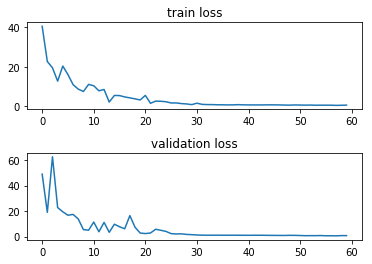

In [87]:
# Plot train/validation loss
train_loss_list = l[0]
test_loss_list = l[1]
print(min(train_loss_list))
print(min(test_loss_list))
epochs = [i for i in range(len(train_loss_list))]
f, ax = plt.subplots(2)
f.subplots_adjust(wspace=0.5, hspace=0.5)
ax[0].set_title("train loss")
ax[0].plot(epochs, train_loss_list)
ax[1].set_title("validation loss")
ax[1].plot(epochs, test_loss_list)


10
name: John J. Crittenden
name: John C. Breckinridge
name: Rutherford B. Hayes
name: Daniel Webster
name: John Tyler
name: Benjamin Ogle Tayloe
name: James A. Garfield
name: Margaret Chase Smith
name: Woodrow Wilson
name: Rubel Phillips
name: Theodore Roosevelt
name: Benjamin Harrison
name: John McCain
name: Thomas R. Marshall
name: Simon Bolivar Buckner
name: Alben W. Barkley
name: Harry S. Truman
name: Pat Buchanan
name: George W. Johnson (governor)
name: Richard Mentor Johnson
name: Barry Goldwater
name: Chester A. Arthur
name: Calvin Coolidge
name: John W. Stevenson
name: Al Gore
name: Luke P. Blackburn
name: Bill Clinton
name: Mark Felt
name: Jesse Helms
name: John Breckinridge (U.S. Attorney General)
Best F1 Score : 0.436363636364


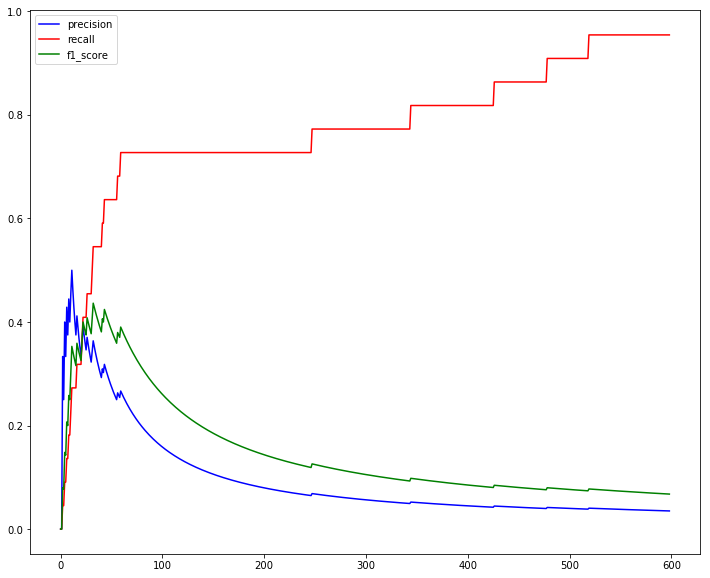

In [88]:
def precision_recall_plot(pagerank_sorted, true_list, k_max=100, title=None):
    list_precision = list()
    list_recall = list()
    list_f1 = list()
    k_max = min(k_max, len(pagerank_sorted))
    for k in range(1, k_max):
        y_pred = pagerank_sorted[:k]
        precision = len(np.intersect1d(np.array(true_list), y_pred)) / float(k)
        recall = len(np.intersect1d(np.array(true_list), y_pred)) / float(len(true_list))
        if precision == 0 and recall== 0:
            f1_score = 0
        else:
            f1_score = 2 * precision * recall / (precision + recall)
        
        list_precision.append(precision)
        list_recall.append(recall)
        list_f1.append(f1_score)
        if recall == 1:
            break
    
    print("Best F1 Score : {}".format(np.max(list_f1)))
    
    list_abs = [k for k in range(len(list_precision))]
    plt.figure(figsize = (12, 10))
    plt.plot(list_abs, list_precision, c="b", label="precision")
    plt.plot(list_abs, list_recall, c="r", label="recall")
    plt.plot(list_abs, list_f1, c="g", label="f1_score")
    plt.legend()
    if title : 
        plt.title(title)
    return np.max(list_f1)



y_pred = np.argsort(np.exp(clf.predict_proba(vect_test_bin_features)[:, 1]))[::-1]
print(len(np.intersect1d(vect_test_id[y_pred[:30]], list_presidents_id)))
for a in y_pred[:30]:
    id = vect_test_id[a]
    show_node(int(id), df_nodes, df_features, df_features_names, show_features=False)
NN_max_F1 = precision_recall_plot(vect_test_id[y_pred], vect_test_id_little, k_max=600)


In [89]:
def presidents_rank(pagerank_sorted, true_list):
    mask = numpy.isin(pagerank_sorted, true_list)
    print(np.sum(mask))
    list_id = np.array(pagerank_sorted)[mask]
    list_id = map(str, list_id)
    list_indices = np.where(mask)
    print(len(list_id))
    for i in range(len(list_id)):
        show_node(int(list_id[i]), df_nodes, df_features, df_features_names, show_features=False)        
        print(list_indices[0][i])
        
presidents_rank(vect_test_id[y_pred], vect_test_id_little)

22
22
name: Rutherford B. Hayes
2
name: John Tyler
4
name: James A. Garfield
6
name: Woodrow Wilson
8
name: Theodore Roosevelt
10
name: Benjamin Harrison
11
name: Harry S. Truman
16
name: Chester A. Arthur
21
name: Calvin Coolidge
22
name: Bill Clinton
26
name: John Quincy Adams
31
name: Andrew Johnson
32
name: Zachary Taylor
41
name: Ulysses S. Grant
43
name: Jimmy Carter
56
name: Warren G. Harding
59
name: George W. Bush
247
name: Franklin D. Roosevelt
344
name: George Washington
426
name: Winfield Scott
478
name: Richard Nixon
519
name: John Adams
899


In [90]:
def non_presidents_rank(pagerank_sorted, true_list):
        mask = numpy.isin(pagerank_sorted, true_list)
        k_max = max(np.where(mask)[0])
        k_max = 10
        mask = ~numpy.isin(pagerank_sorted, true_list)
        list_id = np.array(pagerank_sorted)[mask]
        list_id = map(str, list_id)
        list_indices = np.where(mask)
        for i in range(k_max):
            show_node(int(list_id[i]), df_nodes, df_features, df_features_names, show_features=False)  
            print(list_indices[0][i])

non_presidents_rank(vect_test_id[y_pred], vect_test_id_little)

name: John J. Crittenden
0
name: John C. Breckinridge
1
name: Daniel Webster
3
name: Benjamin Ogle Tayloe
5
name: Margaret Chase Smith
7
name: Rubel Phillips
9
name: John McCain
12
name: Thomas R. Marshall
13
name: Simon Bolivar Buckner
14
name: Alben W. Barkley
15


## Which features does our net consider "important" ?

In [77]:
net = clf.trained_net

In [78]:
print(np.abs(list(net.children())[0].weight.data.numpy()).shape)
l = list(net.children())[0].weight.data.numpy()
print(l.shape)
l_pos = np.array([np.sum(l.T[i][l.T[i] > 0]) for i in range(len(l.T))] )
print(l_pos.shape)
print(np.mean(l_pos), np.std(l_pos))
list_features_pos = np.argsort(l_pos)[::-1]

for feature in list_features_pos[:15]:
    print(l_pos[feature])
    a = np.zeros(len(list_features_pos))
    a[feature]=1
    id = int(lb.inverse_transform(a.reshape(1, -1))[0])
    print(df_features_names[df_features_names["id"] == id]["name"].values[0])


(60, 999)
(60, 999)
(999,)
(0.018761925, 0.048556969)
0.938095
White House
0.722961
Supreme Court of the United States
0.527832
United States House of Representatives
0.347108
United States Senate
0.264291
United States
0.24796
Democratic Party (United States)
0.241308
Republican Party (United States)
0.226934
War of 1812
0.200624
Episcopal Church (United States)
0.199806
United States Navy
0.197134
Washington, D.C.
0.182683
Indiana
0.154836
Virginia
0.126242
Minnesota
0.114724
United States Army


In [79]:
print(np.abs(list(net.children())[0].weight.data.numpy()).shape)
l = list(net.children())[0].weight.data.numpy()
print(l.shape)
l_neg = np.array([np.sum(l.T[i][l.T[i] < 0]) for i in range(len(l.T))] )
print(l_neg.shape)
print(np.mean(l_neg), np.std(l_neg))
list_features_neg = np.argsort(l_neg)
#real_features_names_abs = ["United States", "President of the United States", "Democratic Party", "Republican Party", "Republican"]
#real_features_id_abs = [df_features_names[df_features_names["name"] == a]["id"].values[0] for a in real_features_names_abs]
#real_features_scores_abs = [l_abs[i] for i in real_features_id_abs]
#for i in range(len(real_features_names_abs)):
 #   print(real_features_names_abs[i], real_features_scores_abs[i])

for feature in list_features_neg[:15]:
    print(l_neg[feature])
    a = np.zeros(len(list_features_neg))
    a[feature]=1
    id = int(lb.inverse_transform(a.reshape(1, -1))[0])
    print(df_features_names[df_features_names["id"] == id]["name"].values[0])

(60, 999)
(60, 999)
(999,)
(-0.21195549, 0.090848148)
-0.629198
Democratic Party (United States)
-0.588005
Supreme Court of the United States
-0.579825
United Kingdom
-0.555238
Major League Baseball
-0.517461
National Football League
-0.493702
Washington, D.C.
-0.490679
Italy
-0.487078
England
-0.486333
Japan
-0.485646
California
-0.480271
Defender (association football)
-0.479705
Scotland
-0.47281
Singing
-0.457189
The New York Times
-0.451301
Politician


In [80]:
print(np.abs(list(net.children())[0].weight.data.numpy()).shape)
l_abs = np.sum(np.abs(list(net.children())[0].weight.data.numpy()), axis=0)
print(np.mean(l_abs), np.std(l_abs))
list_features_abs = np.argsort(l_abs)[::-1]
#real_features_names_abs = ["United States", "President of the United States", "Democratic Party", "Republican Party", "Republican"]
#real_features_id_abs = [df_features_names[df_features_names["name"] == a]["id"].values[0] for a in real_features_names_abs]
#real_features_scores_abs = [l_abs[i] for i in real_features_id_abs]
#for i in range(len(real_features_names_abs)):
 #   print(real_features_names_abs[i], real_features_scores_abs[i])

for feature in list_features_abs[:15]:
    print(l_abs[feature])
    a = np.zeros(len(list_features_abs))
    a[feature]=1
    id = int(lb.inverse_transform(a.reshape(1, -1))[0])
    print(df_features_names[df_features_names["id"] == id]["name"].values[0])

(60, 999)
(0.23071741, 0.11509827)
1.31097
Supreme Court of the United States
1.26137
White House
0.898768
United States House of Representatives
0.877157
Democratic Party (United States)
0.717551
United States Senate
0.690836
Washington, D.C.
0.680535
United Kingdom
0.639143
Major League Baseball
0.60301
Republican Party (United States)
0.602568
National Football League
0.591155
United States Navy
0.565535
The New York Times
0.554919
England
0.540186
Singing
0.534796
Italy


# Second method : personalized page rank with presidents as seed set

In [39]:
import networkx as nx
from collections import defaultdict

In [40]:
list_presidents_id = map(str, list_presidents_id)

In [41]:
#graph = nx.read_edgelist("datasets/en-wikipedia.humans.ungraph.txt", comments="#", delimiter="\t")


In [100]:
#graph_nx_file = open("graph_nx_file", "wb")
#cPickle.dump(graph, graph_nx_file)

In [ ]:
graph_nx_file = open("graph_nx_file", "rb")
graph = cPickle.load(graph_nx_file)

In [42]:
df_graph = pd.read_csv("datasets/en-wikipedia.humans.ungraph.names.txt", comment="#", delimiter="\t", names=["id", "name"])

In [43]:
df_graph2 = pd.read_csv("datasets/en-wikipedia.humans.ungraph.txt", comment="#", delimiter="\t", names=["source", "target"])

In [44]:
seed_set = set([id for id in np.concatenate((vect_train_id_little, vect_validation_id_little))])

In [45]:
print(seed_set)

set([239616, 239617, 239751, 280333, 281645, 282523, 281638, 281642, 281643, 241453, 281646, 281651, 281652, 281685, 848214, 281688, 281690, 238700, 286833, 239610, 239612, 280319])


In [46]:
def ppr(graph, seed_set, n_iter=10, alpha=0.85, threshold=1e-6):   
    ppr = {str(node): 1. / float(len(seed_set)) for node in seed_set}
    print(ppr)
    for i in range(n_iter):
        new_ppr = defaultdict(float)
        for node in ppr:
            new_ppr[node] += (1. - alpha) * ppr[node]
            node_degree = graph.degree(node)
            for neighbor in graph.neighbors(node):
                new_ppr[neighbor] += (1. / float(node_degree)) * ppr[node]
        ppr = dict()
        for node in new_ppr:
            if new_ppr[node] > threshold:
                ppr[node] = new_ppr[node]
    return ppr

In [47]:
%%time
ppr_rank = ppr(graph, seed_set)

{'848214': 0.045454545454545456, '281645': 0.045454545454545456, '281646': 0.045454545454545456, '281643': 0.045454545454545456, '281642': 0.045454545454545456, '282523': 0.045454545454545456, '286833': 0.045454545454545456, '239610': 0.045454545454545456, '281690': 0.045454545454545456, '239612': 0.045454545454545456, '239617': 0.045454545454545456, '239616': 0.045454545454545456, '238700': 0.045454545454545456, '241453': 0.045454545454545456, '239751': 0.045454545454545456, '281638': 0.045454545454545456, '280319': 0.045454545454545456, '281652': 0.045454545454545456, '281651': 0.045454545454545456, '280333': 0.045454545454545456, '281685': 0.045454545454545456, '281688': 0.045454545454545456}
CPU times: user 35.9 s, sys: 368 ms, total: 36.3 s
Wall time: 36 s


In [48]:
ppr_rank_sorted= sorted(ppr_rank, key=ppr_rank.get, reverse=True)
for president in seed_set:
    ppr_rank_sorted.remove(str(president))
print(len(ppr_rank_sorted))

203967


In [49]:
print(len(np.intersect1d(vect_test_id_little, ppr_rank_sorted[:40])))

22


In [50]:
for i in range(20):
    show_node(int(ppr_rank_sorted[i]), df_nodes, df_features, df_features_names, show_features=False)

name: George Washington
name: Ulysses S. Grant
name: George W. Bush
name: Franklin D. Roosevelt
name: David J. Eicher
name: Theodore Roosevelt
name: Andrew Johnson
name: Bill Clinton
name: Richard Nixon
name: Robert E. Lee
name: Woodrow Wilson
name: Harry S. Truman
name: John Quincy Adams
name: Jimmy Carter
name: Jefferson Davis
name: Henry Clay
name: Zachary Taylor
name: William Tecumseh Sherman
name: Benjamin Harrison
name: Rutherford B. Hayes


## Analyse results (precision-recall scores)

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

Best F1 Score : 0.791666666667


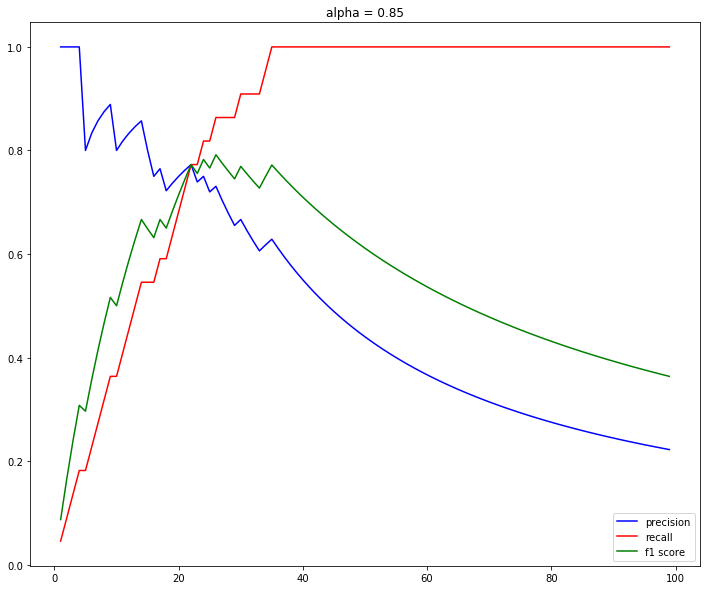

In [52]:
def precision_recall_plot(pagerank_sorted, true_list, k_max=100, title=None):
    list_precision = list()
    list_recall = list()
    list_f1 = list()
    for k in range(1, k_max):
        y_pred = pagerank_sorted[:k]
        precision = len(np.intersect1d(np.array(true_list), y_pred)) / float(k)
        recall = len(np.intersect1d(np.array(true_list), y_pred)) / float(len(true_list))
        if precision == 0 and recall== 0:
            f1_score = 0
        else:
            f1_score = 2 * precision * recall / (precision + recall)
        
        list_precision.append(precision)
        list_recall.append(recall)
        list_f1.append(f1_score)
    
    print("Best F1 Score : {}".format(np.max(list_f1)))
    list_abs = [k for k in range(1, k_max)]
    plt.figure(figsize = (12, 10))
    plt.plot(list_abs, list_precision, c="b", label="precision")
    plt.plot(list_abs, list_recall, c="r", label="recall")
    plt.plot(list_abs, list_f1, c="g", label="f1 score")
    plt.legend()
    if title : 
        plt.title(title)
    return np.max(list_f1)

PPR_max_F1 = precision_recall_plot(ppr_rank_sorted, vect_test_id_little, title="alpha = 0.85")

In [53]:
def presidents_rank(pagerank_sorted, true_list):
    mask = numpy.isin(pagerank_sorted, true_list)
    list_id = np.array(pagerank_sorted)[mask]
    list_id = map(str, list_id)
    list_indices = np.where(mask)
    for i in range(len(list_id)):
        show_node(int(list_id[i]), df_nodes, df_features, df_features_names, show_features=False)        
        print(list_indices[0][i])
presidents_rank(ppr_rank_sorted, np.array(vect_test_id_little).astype(str))

name: George Washington
0
name: Ulysses S. Grant
1
name: George W. Bush
2
name: Franklin D. Roosevelt
3
name: Theodore Roosevelt
5
name: Andrew Johnson
6
name: Bill Clinton
7
name: Richard Nixon
8
name: Woodrow Wilson
10
name: Harry S. Truman
11
name: John Quincy Adams
12
name: Jimmy Carter
13
name: Zachary Taylor
16
name: Benjamin Harrison
18
name: Rutherford B. Hayes
19
name: John Adams
20
name: John Tyler
21
name: Winfield Scott
23
name: Chester A. Arthur
25
name: Calvin Coolidge
29
name: James A. Garfield
33
name: Warren G. Harding
34


In [54]:
def non_presidents_rank(pagerank_sorted, true_list):
        mask = numpy.isin(pagerank_sorted, true_list)
        print(mask)
        k_max = max(np.where(mask)[0])
        mask = ~numpy.isin(pagerank_sorted, true_list)
        list_id = np.array(pagerank_sorted)[mask]
        list_id = map(str, list_id)
        list_indices = np.where(mask)
        for i in range(k_max):
            show_node(int(list_id[i]), df_nodes, df_features, df_features_names, show_features=False)  
            print(list_indices[0][i])

non_presidents_rank(ppr_rank_sorted, np.array(vect_test_id_little).astype(str))

[ True  True  True ..., False False False]
name: David J. Eicher
4
name: Robert E. Lee
9
name: Jefferson Davis
14
name: Henry Clay
15
name: William Tecumseh Sherman
17
name: John C. Breckinridge
22
name: Benjamin Franklin
24
name: John C. Frémont
26
name: Stonewall Jackson
27
name: George B. McClellan
28
name: Gilbert du Motier, Marquis de Lafayette
30
name: Attorneys in the United States
31
name: John C. Calhoun
32
name: Daniel Webster
35
name: Aaron Burr
36
name: Stephen A. Douglas
37
name: Joseph E. Johnston
38
name: Alexander Hamilton
39
name: Philip Sheridan
40
name: Napoleon
41
name: John J. Crittenden
42
name: Sam Houston
43
name: William H. Seward
44
name: Horace Greeley
45
name: Lloyd Thurston
46
name: Braxton Bragg
47
name: James Longstreet
48
name: Lewis Cass
49
name: John Marshall
50
name: William Jennings Bryan
51
name: George Armstrong Custer
52
name: Ambrose Burnside
53
name: Mathew Brady
54
name: John McCain
55


# Final results !! Neural network / personal page rank comparison :

In [55]:
print( "PPR : \n Seed set : {} presidents \n Presidents to find : {} among {} people \n Best F1 Score : {} ".format(
    len(seed_set), len(vect_test_id_little), len(list(graph.nodes())), PPR_max_F1))

print( "NN : \n Train set : {} presidents \n Presidents to find : {} among {} people \n Best F1 Score : {} ".format(
    len(vect_train_id_little) + len(vect_validation_id_little), len(vect_test_id_little), len(vect_test_id), NN_max_F1))

PPR : 
 Seed set : 22 presidents 
 Presidents to find : 22 among 731293 people 
 Best F1 Score : 0.791666666667 
NN : 
 Train set : 22 presidents 
 Presidents to find : 22 among 923993 people 
 Best F1 Score : 0.434782608696 
